# Final Project FM







(Due Date: Jan 11, 2024, class time)

Discussion:
1. envelope为什么是对的
2. limiter为什么是对的
3. wrong_psd错在哪里了？
4. avg power的算法讨论，什么时候能用方法1，也就是psd法？
5. simulation SNR的3种错误写法

搜索“哈哈，我是替身”，直接解除注释，可以得到书上原图。但是single plot里面的图片高度有问题，因为cos函数是周期函数，归一化参数不同


### FM modulation Functions


In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Dec  2 15:31:47 2023
Finished on Thu Dec  7 17:44:30 2023

@author: Suhao Wang
"""

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq,fftshift,ifft
import math
    

# Define the message signal
def square_pulse(t,T1,dt,amplitude):
    return np.where((t >= T1-dt/2) & (t <= T1+dt/2), amplitude, 0)

# Generate the FM signal with kf, Fc and mt
def generate_fm_signal(t, Fs, m_t, mykf, myFc, Ac):
    # "np.cumsum(m_t) / Fs" is the integral "array" from -5 (the start of numpy array) to t
    phi_t = 2 * np.pi * myFc * t + 2*np.pi* mykf * np.cumsum(m_t) / Fs  # Phase deviation
    fm_signal = Ac*np.cos(phi_t)  # FM signal
    return fm_signal

### Numerical Approach
#   func. find_bandwidth integarte to get the approximated band width
#   The func. will return the approximated bandwidth。
#   1. calculate bandwidth from Fc to left until 0 and from fc to right until "infinite"
#   2. make sure that fc>fm+kf*Am
def calculate_bandwidth(f, Y, center, accuracy):
    # parameters
    step = (max(f) - min(f)) / len(f)
    n = len(Y)
    n_half = math.floor(n / 2)
    energy = np.zeros(n)
    df = f[1]-f[0]
    step = df
    ## df is 0.1, step 0.099995, but both seems good

    # total energy in positive axis
    energy[0] = step * math.pow(Y[0], 2)
    for i in range(1, n_half):
        energy[i] = energy[i - 1] + step * math.pow(Y[i], 2)

    # band_energy we need in positive axis
    total_energy = energy[n_half-1]
    band_energy = accuracy * total_energy
    
    # move
    center_index = (int)(center*1/step)
    energy[0] = step * math.pow(Y[center_index], 2)

    for i in range(1, n_half-center_index):
        energy[i] = energy[i - 1] + step * math.pow(Y[i+center_index], 2)
        if center_index-i>=0:
            energy[i] = energy[i] + step * math.pow(Y[center_index-i], 2)

        if (energy[i]>band_energy):
            if (center_index-i>=0):
                bandwidth = f[i+center_index]-f[center_index-i]
            else:
                bandwidth = f[i+center_index]
            break

    return round(bandwidth,3)


### FM demodulation functions

In [2]:
import numpy as np
from numpy.fft import fft, fftfreq,fftshift,ifft
import scipy.signal as signal

def differentiate(signal_t,Fs):
    fbin  = fftfreq(len(signal_t), d=1 / Fs)
    signal_f = fft(signal_t)/Fs
    differentiated_spectrum = (2*np.pi*1j*fbin) * signal_f 
    differentiated_signal = ifft(differentiated_spectrum).real*Fs
    return differentiated_signal

def discriminator(signal_t,Fs):
    differentiated_signal = differentiate(signal_t,Fs)
    result_t = np.abs(signal.hilbert(differentiated_signal))
    return result_t

### filter
def mask(f,X_f, f_low,f_high):
    mask1 = np.logical_and(f >= f_low, f <= f_high)
    mask2 = np.logical_and(f >= -f_high, f <= -f_low)
    mask = np.logical_or(mask1,mask2)
    X_f = X_f * mask
    return X_f

def Filter(Fs, signal, f_low,f_high):
    recv_fbin = fftfreq(len(signal),d=1/Fs)
    recv_f = fft(signal)/Fs  
    x_f2 = mask(recv_fbin,recv_f,f_low,f_high)
    x_t2 = ifft(x_f2).real*Fs
    return x_t2


def demodulation(t, recv_signal,Fs,fm_BT,m_bw,Fc,sampe_center=0):
    # band-pass filter
    x_t2 = Filter(Fs,recv_signal,Fc-fm_BT/2,Fc+fm_BT/2)
    # method2, BPF的Bc意思是得到[fc-Bc/2,fc+Bc/2],h = 2Bcsinc(Bct)*cos(2pi*fc*t)
    # Bc2 = fm_BT
    # h_hp = 2*Bc2*np.sinc(Bc2*(t-sampe_center))*np.cos(2*np.pi*Fc*t)
    # x_t2 = np.convolve(recv_signal, h_hp,'same')/Fs

    # limiter
    envelope = np.abs(signal.hilbert(x_t2))
    limited_t2 = 0.5*(2*x_t2-envelope)/envelope + 0.5

    # discriminator = differentiate + envelope detector 
    ## envelope = 2*pi*fc + 2*pi*kf*m_t
    envelope2 = discriminator(limited_t2,Fs) 
    v_t2 = (envelope2 - 2*np.pi*Fc)/(2*np.pi)

    # low-pass filter
    output_t2 = Filter(Fs,v_t2,0,m_bw)
    # method2, LPF的Bc意思是得到[-Bc,Bc],h = 2Bcsinc(2Bct)
    # Bc = m_bw          
    # h_lp = 2*Bc*np.sinc(2*Bc*(t-sampe_center))
    # output_t2 = np.convolve(v_t2,h_lp,'same')/Fs  #归一化

    return x_t2,limited_t2,v_t2,output_t2


![final project FM block diagram.PNG](<attachment:final project FM block diagram.PNG>)
Note: 
1. assume discriminator = differentiate + envelope detector, then envelope2 is the direct output of discriminator. v(t) needs more operation to get.
2. Blue part is not used in the code. We assume that $recv_t = fm_t + w_t$ directly. In practice, the $fm_t$, centering at $Fc$, should be moved to $Fc+Fr$. Radio transmission requires larger frequency.
3. limiter will use the Auxiliary Angle formula and delete the original amplitude of $x\_t$ which is useless.
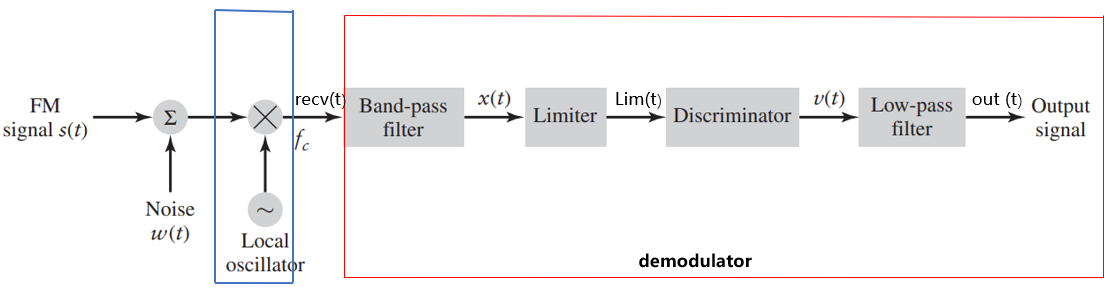

$x\_t = fm\_t + n\_t$, where $n\_t$ is passing BPF w_t

$limited\_t = cos(2*\pi*fc*t+\theta(t))$, where $\theta$ is shown below:

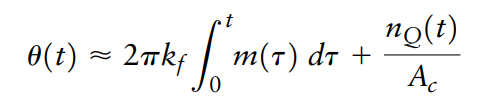

$envelope2 = 2*\pi*fc + 2*\pi*kf*m\_t + 2*\pi*nd\_t$

$v\_t = kf*m\_t + nd\_t$

$output\_t = kf*m\_t$

### Power functions

In [27]:
import numpy as np
from numpy.fft import fft, fftfreq
import scipy.signal as signal

def wrong_PSD(any_t,Fs):
    any_fbin = (fftfreq(len(any_t), d=1 / Fs))
    any_f = np.abs((fft(any_t)))
    any_f = any_f/Fs

    psd = any_f**2
    return any_fbin,psd


def PSD(any_t,Fs):
    # nperseg should be smaller than number of any_t
    any_fbin, psd = signal.welch(any_t, fs=Fs, nperseg=2048, noverlap = int(2048*2/4),return_onesided=False)
    return any_fbin,psd


def average_power(any_t,Fs):
    # method 1, it's wrong if any_t is energy signal
    # f,Y = PSD(any_t,Fs)
    # step = (max(f)-min(f))/len(f)
    # result = np.sum(Y)*step

    # method 2, it's always true
    result = np.mean(np.square(any_t))
    return result

### plt function

In [4]:
import numpy as np
import matplotlib.pyplot as plt
def draw(t, signal_t, f, signal_f, signal_name,tmin=-2.5,tmax=2.5,fmin=-150,fmax=150):
    plt.figure(figsize=(16, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t, signal_t)
    plt.title(signal_name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.xlim(tmin,tmax)  
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(fftshift(f), np.abs(fftshift(signal_f)))
    plt.title(signal_name)
    plt.xlabel('frequency(Hz)')
    plt.ylabel('magnitude')
    plt.xlim(fmin,fmax)  
    plt.grid()

## 1. Single Call

### Global Parameters

In [5]:
from numpy.fft import fft, fftfreq
import numpy as np
# numerical values
T = 5
Fs = 2000                   # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval


### message signal
notice that message signal should be non-periodic function, otherwise, the figures magnitude is wrong.

In [6]:
# message signal
duration = 4  # rect(t/duration)
Am = 1        # the rectangular pulse amplitude is fixed to 1
m_t = square_pulse(t,0,duration,Am)
# m_t = np.sin(2*np.pi*t)   ### 哈哈，我是替身

### modulation
notice that $Fc$ should be larger than $kf*Am$ and $T$ should be larger than $duration/2$


In [7]:
# Define the parameters
Fc = 70       # Carrier frequency (Hz)
kf = 30       # Frequency sensitivity (Hz/Volt), 
# kf = 20      ### 哈哈，我是替身
Ac = 1       # carrier amplitude

# fm_signal
fm_t = generate_fm_signal(t, Fs, m_t, kf, Fc, Ac)

### calculate BW of message signal and FM signal

In [8]:
m_fbin = fftfreq(len(m_t), d=1 / Fs)
m_f = fft(m_t)/Fs   #非周期函数归一化要乘以1/fs
fm_fbin = fftfreq(len(fm_t), d=1 / Fs)
fm_f = fft(fm_t)/Fs   #FM 信号虽然是cos，但是仍然是非周期函数
fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.999)
m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.999)    
# fm_bw = 62.5  ### 哈哈，我是替身
# m_bw = 5.5    ### 哈哈，我是替身
print(fm_bw)
print(m_bw)


66.2
18.1


### demodulation without noise

In [9]:
# add noise
recv_t2 = fm_t

# demodulation
x_t2, limited_t2, v_t2, output_t2 = demodulation(t, recv_t2, Fs, fm_bw, m_bw, Fc, sampe_center=0)


### Noisy signal demodulation

In [10]:
import numpy as np
from numpy.fft import fft, fftshift

# add noise
noise_size = 1
w_t = noise_size*np.random.randn(t.size)
recv_t = w_t + fm_t

# demodulation
x_t, limited_t, v_t, output_t = demodulation(t, recv_t, Fs, fm_bw, m_bw, Fc, sampe_center=0)


### plot figures

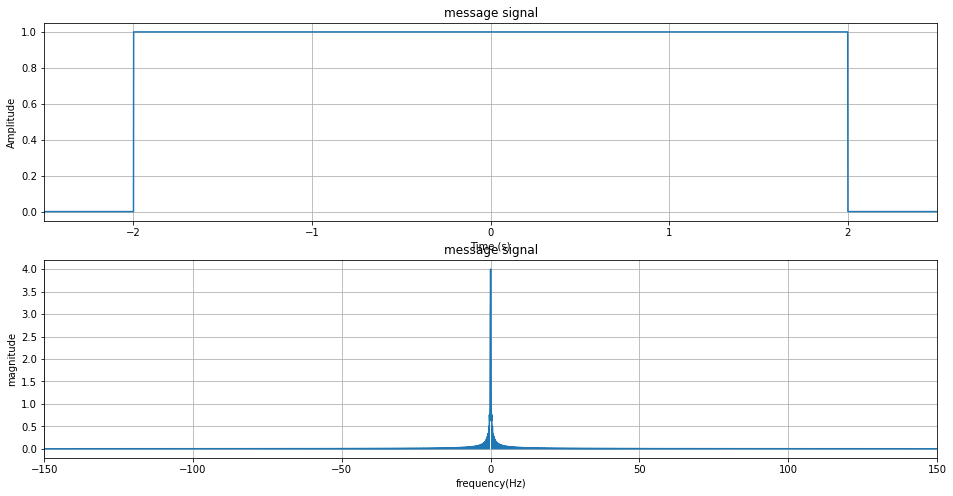

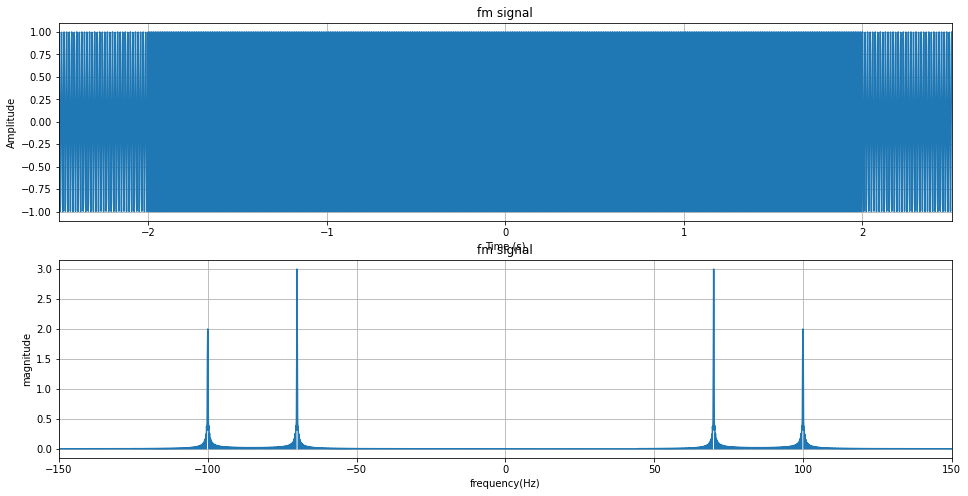

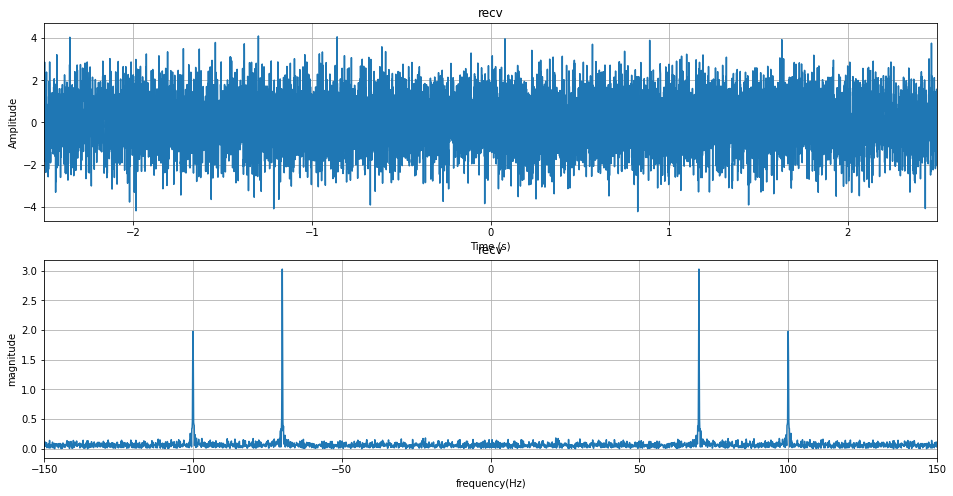

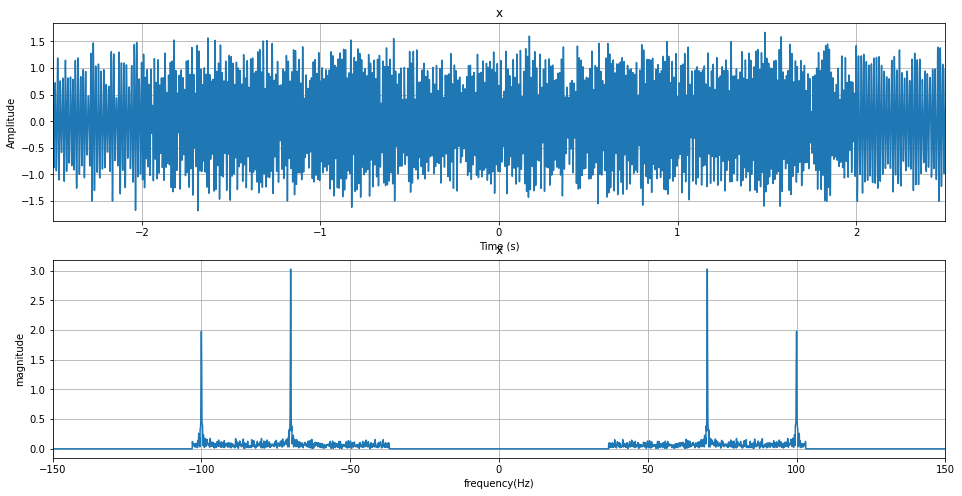

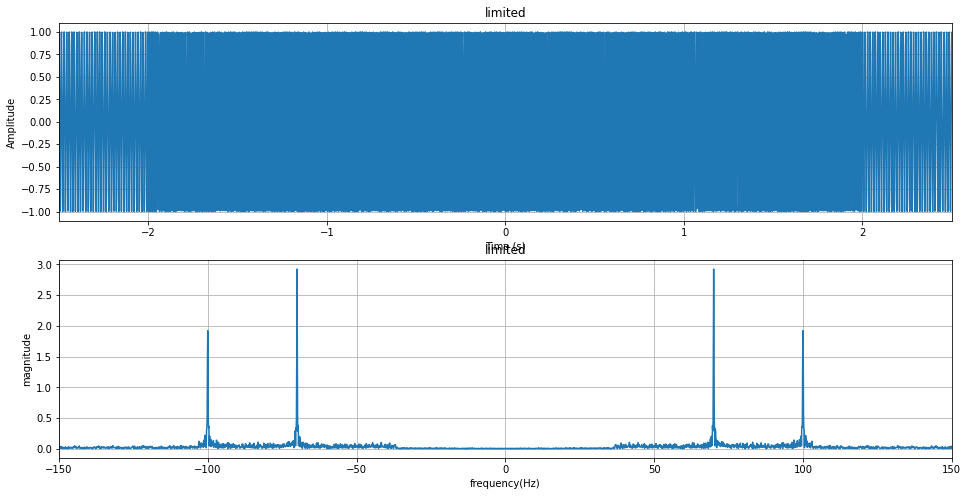

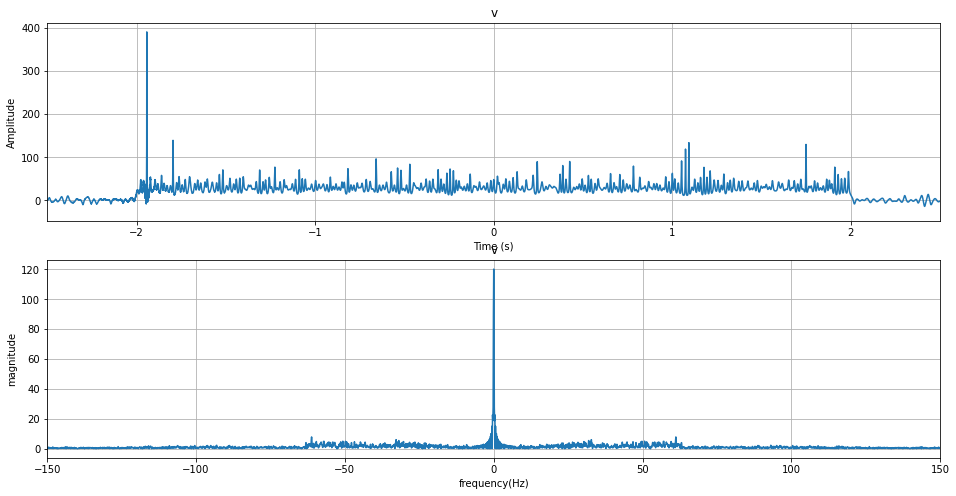

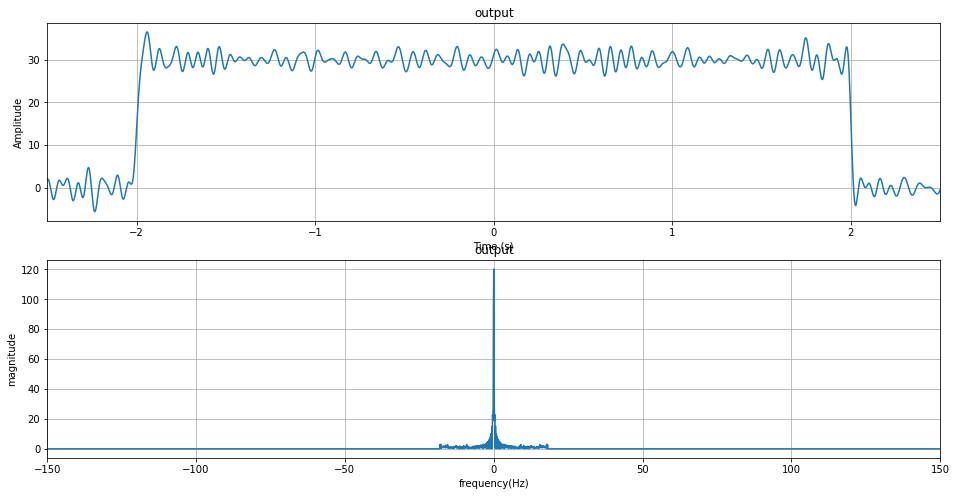

In [11]:
# get freq domain
recv_f = fft(recv_t)/Fs  
x_f = fft(x_t)/Fs
limited_f = fft(limited_t)/Fs
v_f = fft(v_t)/Fs
output_f = fft(output_t)/Fs
draw(t,m_t,m_fbin,m_f,"message signal")
draw(t,fm_t,fm_fbin,fm_f,"fm signal")
draw(t,recv_t,fm_fbin,recv_f,'recv')
draw(t,x_t,fm_fbin,x_f,"x")
draw(t,limited_t,fm_fbin,limited_f,"limited")
draw(t,v_t,fm_fbin,v_f,"v")
draw(t,output_t,fm_fbin,output_f,"output")

### Pre SNR Comparision

In [12]:
# Simulation = average_power(x_t2,Fs)/ (average_power(x_t ,Fs) - (average_power(x_t2 ,Fs)))

Simulation = average_power(x_t2,Fs)/ (average_power(x_t - x_t2 ,Fs))

fbin, psd = PSD(w_t,Fs)
N0 = np.mean(psd)*2   # N0/2 is the amplitude of white noise, thus multiply 2
BT = fm_bw
theoretical = Ac**2/(2*N0*BT)

print("N0 is:",N0)
print("band-pass signal BT is:", BT)
print("pre_SNR is:",theoretical)
print("pre_SNR simulation is:",Simulation)

print(average_power(x_t2,Fs))
print(average_power(x_t,Fs))

N0 is: 0.0009927337431405944
band-pass signal BT is: 66.2
pre_SNR is: 7.608152883713127
pre_SNR simulation is: 7.6293568221362245
0.49948906824449885
0.5514917642491736


### post SNR Comparision

In [13]:
# Simulation = average_power(kf*m_t,Fs)/ (average_power(output_t,Fs) - average_power(kf*m_t,Fs)) 
# Simulation = average_power(kf*m_t,Fs)/ (average_power(output_t - kf*m_t,Fs))
## 这两个是错的
# SNR is smaller than the theoretic value，因为对于signal的power都使用了理论值
# 实际上，通过BPF和LPF都会对signal的power产生损耗
# That's why we need demodulation without noise first

## 这个也是错的
#Simulation = average_power(output_t2,Fs)/ (average_power(output_t,Fs) - average_power(output_t2,Fs)) 

Simulation = average_power(output_t2,Fs)/ (average_power(output_t - output_t2,Fs)) 

fbin, psd = PSD(w_t,Fs)
N0 = np.mean(psd)*2
W = m_bw 
P = average_power(m_t,Fs)
theoretical = 3*Ac**2*kf**2*P/(2*N0*W**3)
print("simulation is:",Simulation)
print("theoretical is:",theoretical)

print("W is:",W)
print("N0 is:",N0)

print(average_power(output_t2,Fs))
print(average_power(output_t,Fs))



simulation is: 118.2821825234027
theoretical is: 91.73292704925116
W is: 18.1
N0 is: 0.0009927337431405944
359.2752284118852
362.988485821024


## 2. multiple calls

### all steps except noisy demodulation

In [14]:
# numerical values
T = 5
Fs = 2000                   # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval

# message signal
duration = 4  # rect(t/duration)
Am = 1        # the rectangular pulse amplitude is fixed to 1
m_t = square_pulse(t,0,duration,Am)
# m_t = np.sin(2*np.pi*t) ### 哈哈，我是替身

# fm signal
Fc = 70       # Carrier frequency (Hz)
kf = 56       # Frequency sensitivity (Hz/Volt),
# kf = 20       ### 哈哈，我是替身 
Ac = 100       # carrier amplitude
fm_t = generate_fm_signal(t, Fs, m_t, kf, Fc, Ac)

# calculate fm_bw and W, used in demodulation
m_fbin = fftfreq(len(m_t), d=1 / Fs)
m_f = fft(m_t)/Fs     
fm_fbin = fftfreq(len(fm_t), d=1 / Fs)
fm_f = fft(fm_t)/Fs   
fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.999)
m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.999)   
# fm_bw = 62.5   ### 哈哈，我是替身
# m_bw = 5.      ### 哈哈，我是替身

# demodulation without noise
### add noise
recv_t2 = fm_t
### demodulation 
x_t2, limited_t2, v_t2, output_t2 = demodulation(t, recv_t2, Fs, fm_bw, m_bw, Fc, sampe_center=0)


### plot comparision

In [15]:
# Define a function that takes the parameter as an input and performs the desired computation
# change noise size 
fixed_w_t = np.random.randn(t.size)
def compute_table_value(parameter):
    # Perform computations or calculations based on the parameter value
    
    # demodulation with noise
    ### add noise
    noise_size = parameter
    w_t = noise_size*np.random.randn(t.size)
    recv_t = w_t + fm_t
    ### demodulation
    # fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.999)
    # m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.999)     
    x_t, limited_t, v_t, output_t = demodulation(t, recv_t, Fs, fm_bw, m_bw, Fc, sampe_center=0)


    # simulation SNR
    pre_snr = average_power(x_t2,Fs)/ (average_power(x_t - x_t2 ,Fs))
    post_snr = average_power(output_t2,Fs)/ (average_power(output_t - output_t2,Fs)) 

    # theoretical SNR
    fbin, psd = PSD(w_t,Fs)
    N0 = np.mean(psd)*2
    BT = fm_bw
    W = m_bw 
    P = average_power(m_t,Fs)

    theoretical_pre = Ac**2/(2*N0*BT)
    theoretical_post = 3*Ac**2*kf**2*P/(2*N0*W**3)

    return 10*np.log10(pre_snr), 10*np.log10(post_snr), 10*np.log10(theoretical_pre), 10*np.log10(theoretical_post)

# Define the range of values for the parameter
parameter_values = range(50, 150)  # Example range, modify according to your needs

# Generate the table by iterating over the parameter values
for value in parameter_values:
    # Compute the corresponding table value for each parameter value
    pre,post,t_pre,t_post = compute_table_value(value)
    # Print the parameter value and the corresponding table value
    print(f"pre-SNR: {pre}, post-SNR: {post}, theoretical_pre_SNR:{t_pre}, theoretical_post_SNR:{t_post}")

pre-SNR: 12.099149978777756, post-SNR: 30.779650914467787, theoretical_pre_SNR:12.152431953711151, theoretical_post_SNR:30.925812114687616
pre-SNR: 12.10123069739926, post-SNR: 31.258816976816163, theoretical_pre_SNR:12.165847565034028, theoretical_post_SNR:30.939227726010493
pre-SNR: 12.031047323703536, post-SNR: 31.585586464289793, theoretical_pre_SNR:11.897066730455489, theoretical_post_SNR:30.670446891431954
pre-SNR: 11.768369095510838, post-SNR: 31.689790769011154, theoretical_pre_SNR:11.79036718961167, theoretical_post_SNR:30.563747350588137
pre-SNR: 11.38904382755203, post-SNR: 30.728083727539616, theoretical_pre_SNR:11.589665773167532, theoretical_post_SNR:30.363045934144
pre-SNR: 11.518544762285828, post-SNR: 30.419957696114924, theoretical_pre_SNR:11.400981689341172, theoretical_post_SNR:30.17436185031764
pre-SNR: 11.282128136024884, post-SNR: 31.050830600188483, theoretical_pre_SNR:11.345793646765816, theoretical_post_SNR:30.119173807742282


pre-SNR: 11.055396274081295, post-SNR: 30.841458706925234, theoretical_pre_SNR:11.115634072714382, theoretical_post_SNR:29.88901423369085
pre-SNR: 11.134066021401132, post-SNR: 30.59617576988378, theoretical_pre_SNR:10.894670684220474, theoretical_post_SNR:29.668050845196937
pre-SNR: 10.798823407776988, post-SNR: 30.698887498291242, theoretical_pre_SNR:10.840961310830448, theoretical_post_SNR:29.614341471806913
pre-SNR: 10.658123124091901, post-SNR: 30.76445007393987, theoretical_pre_SNR:10.748272743514969, theoretical_post_SNR:29.521652904491432
pre-SNR: 10.58887098057623, post-SNR: 30.07141786994933, theoretical_pre_SNR:10.54854220702283, theoretical_post_SNR:29.3219223679993
pre-SNR: 10.48201880885507, post-SNR: 30.313086808792683, theoretical_pre_SNR:10.38191283407415, theoretical_post_SNR:29.155292995050615
pre-SNR: 10.394149952697589, post-SNR: 30.216067772158624, theoretical_pre_SNR:10.21287148904011, theoretical_post_SNR:28.986251650016577
pre-SNR: 10.197304613605544, post-SNR:

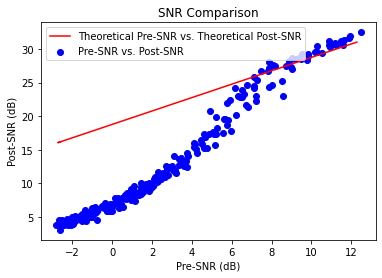

In [16]:
import matplotlib.pyplot as plt

# Define the range of values for the parameter
parameter_values = range(50, 280)  # Example range, modify according to your needs

# Initialize empty lists to store the computed table values
pre_snr_values = []
post_snr_values = []
theoretical_pre_snr_values = []
theoretical_post_snr_values = []

# Iterate over the parameter values and compute the table values
for value in parameter_values:
    pre, post, t_pre, t_post = compute_table_value(value)
    pre_snr_values.append(pre)
    post_snr_values.append(post)
    theoretical_pre_snr_values.append(t_pre)
    theoretical_post_snr_values.append(t_post)

# Create a figure with pre-SNR vs. post-SNR and theoretical pre-SNR vs. theoretical post-SNR
fig, ax = plt.subplots()
ax.scatter(pre_snr_values, post_snr_values, label='Pre-SNR vs. Post-SNR', color='blue')
ax.plot(theoretical_pre_snr_values, theoretical_post_snr_values, label='Theoretical Pre-SNR vs. Theoretical Post-SNR', color='red')
ax.set_xlabel('Pre-SNR (dB)')
ax.set_ylabel('Post-SNR (dB)')
ax.set_title('SNR Comparison')
ax.legend()

# Show the figure
plt.show()

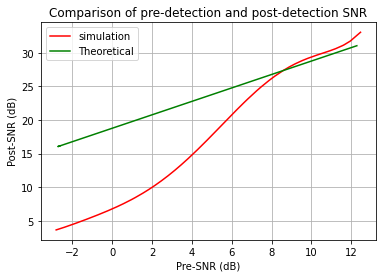

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Perform polynomial regression to fit a curve to the scatter plot
degree = 6  # Degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(np.array(pre_snr_values).reshape(-1, 1))
reg = LinearRegression().fit(X_poly, np.array(post_snr_values).reshape(-1, 1))
fit_line = reg.predict(X_poly)

# Sort the pre-SNR values and corresponding fitted line for smoother visualization
sorted_indices = np.argsort(pre_snr_values)
pre_snr_values_sorted = np.array(pre_snr_values)[sorted_indices]
fit_line_sorted = np.array(fit_line)[sorted_indices]

# Create the scatter plot with pre-SNR on the x-axis and post-SNR on the y-axis, along with the fitted curve
plt.figure()
# plt.scatter(pre_snr_values, post_snr_values, label='Data Points')
plt.plot(pre_snr_values_sorted, fit_line_sorted, color='red', label='simulation')
plt.plot(theoretical_pre_snr_values, theoretical_post_snr_values, label='Theoretical', color='green')
plt.xlabel('Pre-SNR (dB)')
plt.ylabel('Post-SNR (dB)')
plt.title('Comparison of pre-detection and post-detection SNR')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## 3. Effect of parameters

In [18]:
# Define a function that takes the parameter as an input and performs the desired computation
# change noise size 
fixed_w_t = np.random.randn(t.size)
def compute_table_value(parameter):

    # numerical values
    T = 5
    Fs = 2000                   # Sampling frequency (Hz)
    t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval

    # message signal
    duration = 4  # rect(t/duration)
    Am = 1        # the rectangular pulse amplitude is fixed to 1
    Am = parameter/100 ## 另一个测试
    m_t = square_pulse(t,0,duration,Am)
    # m_t = np.sin(2*np.pi*t) ### 哈哈，我是替身

    # fm signal
    Fc = 250       # ensuer Fc>Kf*Am
    kf = parameter # Frequency sensitivity (Hz/Volt),
    kf = 30        ## 另一个测试
    Ac = 100       # carrier amplitude
    fm_t = generate_fm_signal(t, Fs, m_t, kf, Fc, Ac)

    # calculate fm_bw and W, used in demodulation
    m_fbin = fftfreq(len(m_t), d=1 / Fs)
    m_f = fft(m_t)/Fs     
    fm_fbin = fftfreq(len(fm_t), d=1 / Fs)
    fm_f = fft(fm_t)/Fs   
    fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.999)
    m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.999)   

    # demodulation without noise
    ### add noise
    recv_t2 = fm_t
    ### demodulation 
    x_t2, limited_t2, v_t2, output_t2 = demodulation(t, recv_t2, Fs, fm_bw, m_bw, Fc, sampe_center=0)
    
    # demodulation with noise
    ### add noise
    noise_size = 15
    w_t = noise_size*np.random.randn(t.size)
    recv_t = w_t + fm_t
    ### demodulation
    # fm_bw = calculate_bandwidth(fm_fbin,abs(fm_f),Fc,0.999)
    # m_bw = calculate_bandwidth(m_fbin,abs(m_f), 0, 0.999)     
    x_t, limited_t, v_t, output_t = demodulation(t, recv_t, Fs, fm_bw, m_bw, Fc, sampe_center=0)


    # simulation SNR
    pre_snr = average_power(x_t2,Fs)/ (average_power(x_t - x_t2 ,Fs))
    post_snr = average_power(output_t2,Fs)/ (average_power(output_t - output_t2,Fs)) 

    # theoretical SNR
    fbin, psd = PSD(w_t,Fs)
    N0 = np.mean(psd)*2
    BT = fm_bw
    W = m_bw 
    P = average_power(m_t,Fs)

    theoretical_pre = Ac**2/(2*N0*BT)
    theoretical_post = 3*Ac**2*kf**2*P/(2*N0*W**3)

    return Am, post_snr, theoretical_post    ## 另一个测试
    return kf, post_snr, theoretical_post


# Define the range of values for the parameter
parameter_values = range(50, 60)  # Example range, modify according to your needs

# Generate the table by iterating over the parameter values
for value in parameter_values:
    # Compute the corresponding table value for each parameter value
    para,post,t_post = compute_table_value(value)
    # Print the parameter value and the corresponding table value
    print(f"para: {para}, post-SNR: {post}, theoretical_post_SNR:{t_post}")

para: 0.5, post-SNR: 1132.9881097783125, theoretical_post_SNR:1000.0599808619107
para: 0.51, post-SNR: 1342.4804319858313, theoretical_post_SNR:1039.4605795643452
para: 0.52, post-SNR: 1199.3058723118043, theoretical_post_SNR:1108.6695777065631
para: 0.53, post-SNR: 1256.2690199743422, theoretical_post_SNR:1145.505926552454
para: 0.54, post-SNR: 1606.1927182811974, theoretical_post_SNR:1171.331847598941
para: 0.55, post-SNR: 1350.5381747443846, theoretical_post_SNR:1235.3879862783176
para: 0.56, post-SNR: 1841.9558110921387, theoretical_post_SNR:1282.6162912247255
para: 0.57, post-SNR: 1484.4871354941656, theoretical_post_SNR:1307.7408245568474
para: 0.58, post-SNR: 1609.1152980605189, theoretical_post_SNR:1359.5795097497871
para: 0.59, post-SNR: 1730.9268554795344, theoretical_post_SNR:1419.1202194528162


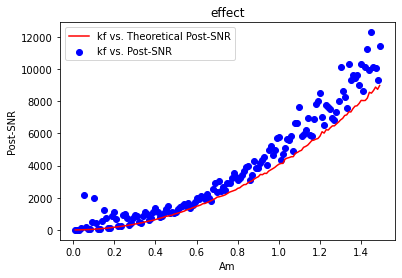

In [19]:
import matplotlib.pyplot as plt

# Define the range of values for the parameter
parameter_values = range(1, 150)  # Example range, modify according to your needs

# Initialize empty lists to store the computed table values
kf_values = []
post_snr_values = []
theoretical_post_snr_values = []

# Iterate over the parameter values and compute the table values
for value in parameter_values:
    kf, post, t_post = compute_table_value(value)
    kf_values.append(kf)
    post_snr_values.append(post)
    theoretical_post_snr_values.append(t_post)

# Create a figure with pre-SNR vs. post-SNR and theoretical pre-SNR vs. theoretical post-SNR
fig, ax = plt.subplots()
ax.scatter(kf_values, post_snr_values, label='kf vs. Post-SNR', color='blue')
ax.plot(kf_values, theoretical_post_snr_values, label='kf vs. Theoretical Post-SNR', color='red')
ax.set_xlabel('kf')
ax.set_xlabel('Am')    ## 另一个测试
ax.set_ylabel('Post-SNR')
ax.set_title('effect')
ax.legend()

# Show the figure
plt.show()

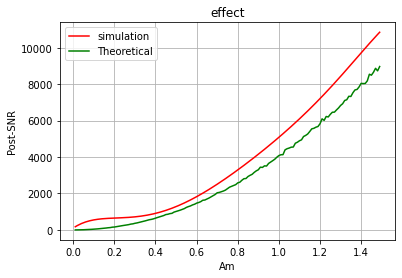

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Perform polynomial regression to fit a curve to the scatter plot
degree = 6  # Degree of the polynomial
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(np.array(kf_values).reshape(-1, 1))
reg = LinearRegression().fit(X_poly, np.array(post_snr_values).reshape(-1, 1))
fit_line = reg.predict(X_poly)

# Sort the pre-SNR values and corresponding fitted line for smoother visualization
sorted_indices = np.argsort(kf_values)
kf_sorted = np.array(kf_values)[sorted_indices]
fit_line_sorted = np.array(fit_line)[sorted_indices]

# Create the scatter plot with pre-SNR on the x-axis and post-SNR on the y-axis, along with the fitted curve
plt.figure()
# plt.scatter(pre_snr_values, post_snr_values, label='Data Points')
plt.plot(kf_sorted, fit_line_sorted, color='red', label='simulation')
plt.plot(kf_values, theoretical_post_snr_values, label='Theoretical', color='green')
plt.xlabel('kf')
plt.xlabel('Am')     ## 另一个测试
plt.ylabel('Post-SNR')
plt.title('effect')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## 4. Appendix

### limiter test

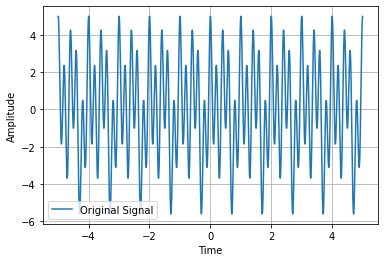

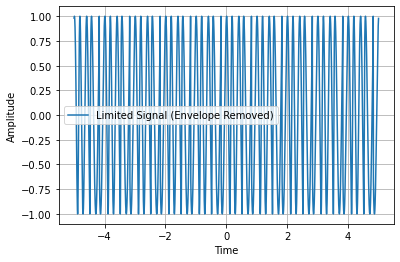

In [21]:
import numpy as np
import scipy.signal as signal
from scipy import fftpack
import matplotlib.pyplot as plt

original_signal = np.sin(2*np.pi*1*t) + 2*np.cos(2*np.pi*2*t)+3*np.cos(2*np.pi*5*t)

# envelope detector method 1
hx =fftpack.hilbert(original_signal)
hy = np.sqrt(original_signal**2+hx**2)

# envelope detector method 2, hy = envelope
envelope = np.abs(signal.hilbert(original_signal))

limiter_signal = 0.5*(2*original_signal-envelope)/envelope + 0.5

# Plot the original signal and the limited signal (with removed envelope)
plt.figure()
plt.plot(t, original_signal, label='Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t, limiter_signal, label='Limited Signal (Envelope Removed)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()


plt.show()

### PSD test

In [22]:
import numpy as np
from numpy.fft import fft, fftfreq
import scipy.signal as signal

def test_PSD(any_t,Fs):
    # nperseg should be smaller than number of any_t
    any_fbin, psd = signal.welch(any_t, fs=Fs, nperseg=2048, noverlap = int(2048*2/4),return_onesided=False)
    return any_fbin,psd


def test_average_power(any_t,Fs):
    f,Y = PSD(any_t,Fs)
    step = (max(f)-min(f))/len(f)
    result = np.sum(Y)*step

    # method 2, it's wrong
    # result = np.mean(np.square(x)
    return result

N0 is: 0.0005031610120067712
test_N0 is: 0.0005031610120067712
wrong_N0 is: 0.005043379792839595


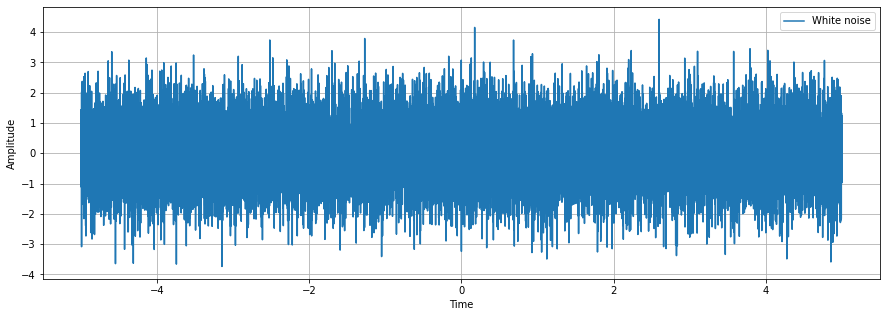

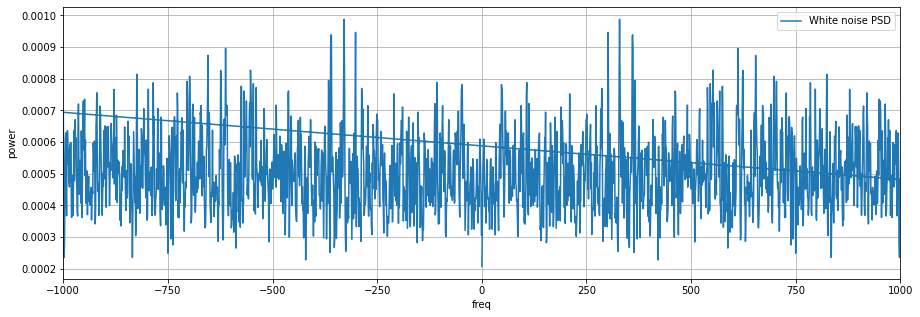

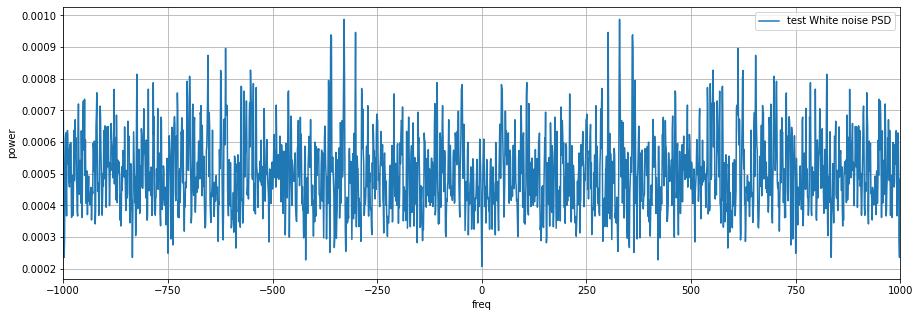

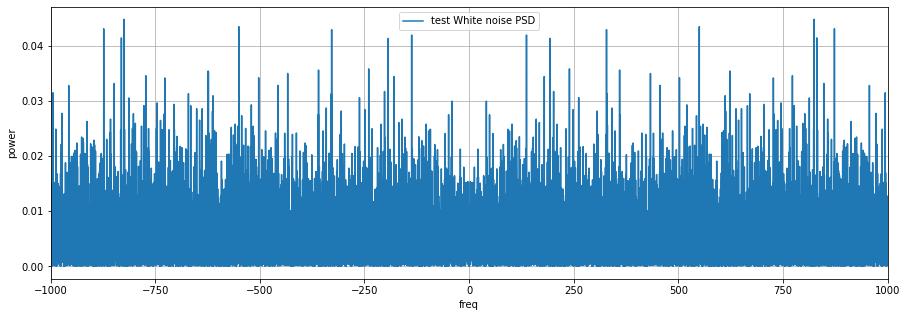

In [29]:
Fs = 2000
w_t = np.random.randn(t.size)
fbin, psd = signal.welch(w_t, fs=Fs, nperseg=2048,noverlap = None, return_onesided=False)
fbin2, psd2 = signal.welch(w_t, fs=Fs, nperseg=2048,noverlap = int(2048*2/4),return_onesided=False)
fbin3, psd3 = wrong_PSD(w_t,Fs)

N0 = np.mean(psd)
print("N0 is:",N0)

test_N0 = np.mean(psd2)
print("test_N0 is:",test_N0)

wrong_N0 = np.mean(psd3)
print("wrong_N0 is:",wrong_N0)

plt.figure(figsize=(15, 5))
plt.plot(t, w_t, label='White noise')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()


plt.figure(figsize=(15, 5))
plt.plot(fbin,psd, label='White noise PSD')
plt.xlabel('freq')
plt.ylabel('power')
plt.legend()
plt.xlim(-1000,1000)
plt.grid()

plt.figure(figsize=(15, 5))
plt.plot(fftshift(fbin2), fftshift(psd2), label='test White noise PSD')
plt.xlabel('freq')
plt.ylabel('power')
plt.legend()
plt.xlim(-1000,1000)
plt.grid()

plt.figure(figsize=(15, 5))
plt.plot(fftshift(fbin3), fftshift(psd3), label='test White noise PSD')
plt.xlabel('freq')
plt.ylabel('power')
plt.legend()
plt.xlim(-1000,1000)
plt.grid()



### Avg power test

In [24]:

T = 5
Fs = 2000                  # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval
N = Fs*2*T                  

x_t = np.cos(2*np.pi*100*t) # 功率信号，有功率谱,因此psd求平均功率可用
print("my function:", test_average_power(x_t,Fs))
print("time domain method 1:",np.mean(np.square(x_t)))
print("time domain method 2:",sum(x_t**2)/N)

w_t = np.random.randn(t.size)    # 随机信号是功率信号，有功率谱,因此psd求平均功率可用
print("w_t avg power is:",test_average_power(w_t,Fs))
print("time domain method 1:",np.mean(np.square(w_t)))
print("time domain method 2:",sum(w_t**2)/N)

energy_signal = square_pulse(t,0,1,1)  #能量信号，没有功率谱，用不了我这个方法
print("my function:", test_average_power(energy_signal,Fs))
print("time domain method 1:",np.mean(np.square(energy_signal)))
print("time domain method 2:",sum(energy_signal**2)/N)




my function: 0.49976026335893886
time domain method 1: 0.4999999999997319
time domain method 2: 0.4999999999997316
w_t avg power is: 0.9967894877896941
time domain method 1: 1.0001537463003607
time domain method 2: 1.000153746300362
my function: 0.023470243541273497
time domain method 1: 0.1
time domain method 2: 0.1


In [25]:
## 展示psd方法对能量信号的荒诞
T = 5
Fs = 2000                  # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval
N = Fs*2*T                  # psd方法对N有要求，必须要大于welch

x  = square_pulse(t,0,3,10)
# x  = x+np.random.randn(N)                                                                        

print("my function:", average_power(x,Fs))
print("time domain method 1:",np.mean(np.square(x)))
print("time domain method 2:",sum(x**2)/N)


T1 = 5
Fs1 = 20000                  # Sampling frequency (Hz)
t1 = np.arange(-T1, T1, 1/Fs1)  # 1/Fs is the interval
N1 = Fs1*2*T1

x1  = square_pulse(t1,0,3,10)
# x  = x+np.random.randn(N)                                                                        

print("my function:", average_power(x1,Fs1))
print("time domain method 1:",np.mean(np.square(x1)))
print("time domain method 2:",sum(x1**2)/N1)

my function: 30.0
time domain method 1: 30.0
time domain method 2: 30.0
my function: 30.0
time domain method 1: 30.0
time domain method 2: 30.0


In [26]:
## psd方法对功率信号挺不错哒
T = 5
Fs = 2000                  # Sampling frequency (Hz)
t = np.arange(-T, T, 1/Fs)  # 1/Fs is the interval
N = Fs*2*T

x  = np.random.randn(N)                                                                         

print("my function:", average_power(x,Fs))
print("time domain method 1:",np.mean(np.square(x)))
print("time domain method 2:",sum(x**2)/N)



my function: 0.997901109381007
time domain method 1: 0.997901109381007
time domain method 2: 0.9979011093810035
